In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import numpy as np
import collections.abc
#py21cmmc needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
#py21cmmc needs the below
np.int = np.int32
#Now import py21cmmc
from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fftpack import fftn, fftshift


# Compute the power spectrum using 3D Fourier transform

def power_spectrum_fft(signal):
    # Compute the power spectrum using the Fourier transform
    fft_signal = np.fft.fftn(signal)
    fft_amplitudes = np.abs(fft_signal) ** 2
    dim = len(signal)
    kfreq = np.fft.fftfreq(dim, d=1.0) * dim
    kfreq3D = np.meshgrid(kfreq, kfreq, kfreq)
    kfreq_norm = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)
    kfreq_norm = kfreq_norm.flatten()
    fft_amplitudes = fft_amplitudes.flatten()
    kfreq_bins = np.arange(0.5, dim//2+1, 1.0)
    kvals = 0.5 * (kfreq_bins[1:] + kfreq_bins[:-1])
    amplitude_bins, _, _ = stats.binned_statistic(kfreq_norm, fft_amplitudes, statistic='mean', bins=kfreq_bins)
    amplitude_bins *= (4/3) * np.pi * (kfreq_bins[1:]**3 - kfreq_bins[:-1]**3)
    # Convert to the dimensionless power spectrum
    amplitude_bins *= (kvals**3)/2*(np.pi**2)
    return amplitude_bins, kvals

def power_spectrum_cmmc(signal):
    # Compute the power spectrum using the p21cmmc package
    ps = p21mc.Likelihood1DPowerCoeval.compute_power(signal, L=100, n_psbins = 100, 
    log_bins = True) 
    return ps   



In [148]:
def plot_power_spectrum(initial_conditions, astro_params, flag_options):
    fig, ax = plt.subplots(4, 3, figsize=(14,16), sharex = True, sharey = True, tight_layout = True)
    ps1_list = []
    ps2_list = []
    redshift_list = [14, 10, 6]
    for i, redshift in enumerate(redshift_list):
        show_cbar = (redshift == 6)
        #######
        # Create perturbed field at the redshift
        perturbed_field = p21c.perturb_field( redshift = redshift, init_boxes = initial_conditions)
        plotting.coeval_sliceplot(perturbed_field, "density", ax=ax[0][i], fig = fig, vmin = -0.5, vmax = 0.9, cbar_label=r'Density Contrast ($\delta_nl\equiv\rho/\overline{\rho}$ -1)')
        ax[0][i].title.set_text('redshit={0}-Density'.format(redshift))

        #######
        # Compute the spin temperatures
        spin_temp = p21c.spin_temperature(
            perturbed_field = perturbed_field,
            zprime_step_factor=1.05,
            astro_params = astro_params,
            flag_options = flag_options
        )
        plotting.coeval_sliceplot(spin_temp, "Ts_box", ax=ax[1][i], fig = fig, vmin = 0, vmax = 1200, cbar_label='Spin Temperature (K)');
        ax[1][i].title.set_text('redshit={0}-Spin Temperature'.format(redshift))
        # Try accessing global_Ts
        #global_Ts = spin_temp.Ts_box_struct.global_Ts
        #print('Global TS at redshit={0} is {1:.4f}'.format(redshift, global_Ts))

        #######
        # Compute ionization
        ionized_field = p21c.ionize_box(
            spin_temp = spin_temp,
            zprime_step_factor=1.05,
            flag_options = flag_options
        )
        plotting.coeval_sliceplot(ionized_field, "xH_box", ax=ax[2][i], fig = fig, vmin = 0, vmax = 1);
        ax[2][i].title.set_text('redshit={0}-Neutral H fraction'.format(redshift))

        #######
        # Compute brightness temperature
        brightness_temp = p21c.brightness_temperature(
            ionized_box = ionized_field,
            perturbed_field = perturbed_field,
            spin_temp = spin_temp,
            flag_options = flag_options
        )
        plotting.coeval_sliceplot(brightness_temp, ax=ax[3][i], fig = fig)
        ax[3][i].title.set_text('redshit={0}-Brightness Temperature'.format(redshift))

        #######
        # Compute Power Spectrum of brightness_temp
        xscale = user_params["BOX_LEN"]
        yscale = 1/(xscale**3)
        ps1 = power_spectrum_cmmc(brightness_temp.brightness_temp)
        ps1_list.append([ps1[0], ps1[1]])
        #ps2 = power_spectrum_fft(brightness_temp.brightness_temp)
        #ps2_list.append([ps2[0]*yscale, ps2[1]/xscale])
    
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()
        
    plt.figure(figsize=(14,8))
    for i, ps in enumerate(ps1_list):
        plt.plot(ps[1], ps[0], label = 'p21cmmc: z={0}'.format(redshift_list[i]))
    for i, ps in enumerate(ps2_list):
        plt.plot(ps[1], ps[0], label = 'fft: z={0}'.format(redshift_list[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0, 1.2)
    plt.title('Power Spectrum')
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('P(k) ($\Delta^2$) (mK$^2$)')
    plt.legend()
    plt.show()
    


/opt/miniconda3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


ValueError: flag_options has an inconsistent value with TsBox.Expected:

FlagOptions:
    APPLY_RSDS             : True
    FIX_VCB_AVG            : False
    INHOMO_RECO            : False
    M_MIN_in_Mass          : True
    PHOTON_CONS            : False
    SUBCELL_RSD            : False
    USE_CMB_HEATING        : True
    USE_HALO_FIELD         : False
    USE_LYA_HEATING        : True
    USE_MASS_DEPENDENT_ZETA: True
    USE_MINI_HALOS         : False
    USE_TS_FLUCT           : False
    

Got:

FlagOptions:
    APPLY_RSDS             : True
    FIX_VCB_AVG            : False
    INHOMO_RECO            : False
    M_MIN_in_Mass          : True
    PHOTON_CONS            : False
    SUBCELL_RSD            : False
    USE_CMB_HEATING        : True
    USE_HALO_FIELD         : False
    USE_LYA_HEATING        : True
    USE_MASS_DEPENDENT_ZETA: True
    USE_MINI_HALOS         : False
    USE_TS_FLUCT           : True
    .

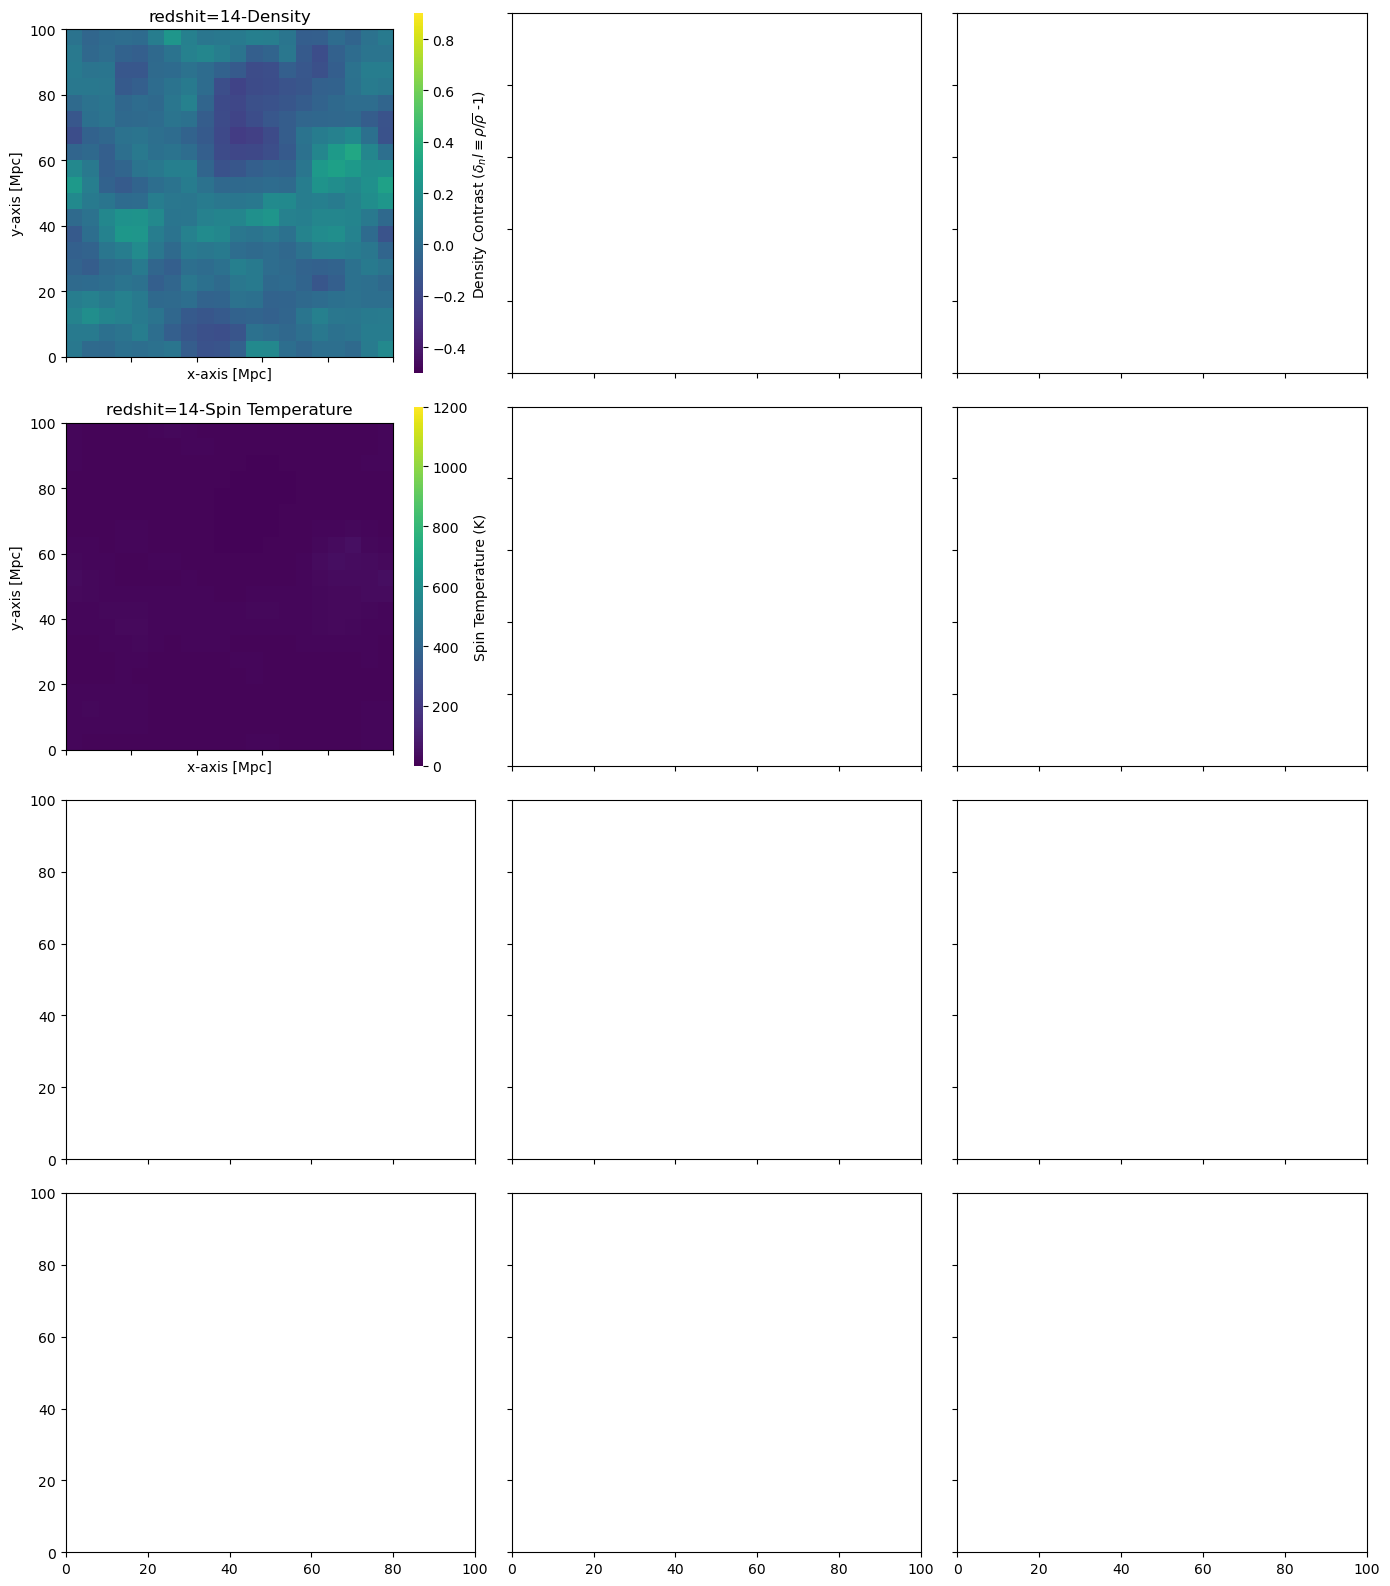

In [149]:
import math

user_params = {"HII_DIM": 20, "BOX_LEN": 100}
astro_params = {"F_STAR10": 0.5} 
flag_options = {"USE_MASS_DEPENDENT_ZETA": True, "USE_TS_FLUCT": True}


initial_conditions = p21c.initial_conditions(
    user_params = user_params
    )
plot_power_spectrum(initial_conditions, astro_params, flag_options)